# Data Conversion and Data Cleaning

In [1]:
import pandas as pd
import sqlite3

Import countries code csv file to generate Id for each records.\
Source: https://gist.github.com/tadast/8827699

In [2]:
country_code = pd.read_csv('data/countries_codes_and_coordinates.csv')
country_code = country_code.loc[:, ['Country', 'Alpha-3 code']]
country_code["Alpha-3 code"] = country_code["Alpha-3 code"].str[2:5]
country_code = country_code.set_index("Country")
T = country_code.to_dict()
T = T["Alpha-3 code"]

Convert each tables from https://www.kaggle.com/datasets/navinmundhra/world-mortality to tidy format.

In [3]:
#adult table for Adult mortality:
adult = pd.read_csv('data/Adult mortality.csv', header=1)
adult["Id"] = adult["Country"].map(T)
adult["Id"] = adult["Id"] + adult["Year"].map(str)
adult = adult[['Id', 'Country', 'Year', 'Both sexes', 'Male', 'Female']]
adult.head()

,Id,Country,Year,Both sexes,Male,Female
0,AFG2016,Afghanistan,2016,245,272,216
1,AFG2015,Afghanistan,2015,233,254,210
2,AFG2014,Afghanistan,2014,234,254,213
3,AFG2013,Afghanistan,2013,235,254,215
4,AFG2012,Afghanistan,2012,242,262,221


In [4]:
def ratio_extract(x):
    for i in range(len(x)):
        if x[i] == '[':
            res = str(x[:i]).replace(" ", "")
            if res == '':
                return 0
            else:
                return int(res)

In [5]:
#maternal table for Maternal mortality:
maternal = pd.read_csv('data/Maternal mortality.csv', header=0)
maternal = maternal.rename({'Maternal mortality ratio (per 100 000 live births)': 'Maternal mortality ratio'}, axis=1)
maternal["Id"] = maternal["Country"].map(T)
maternal["Id"] = maternal["Id"] + maternal["Year"].map(str)
maternal["Maternal mortality ratio"] = maternal["Maternal mortality ratio"].apply(lambda x: ratio_extract(x))
maternal["Number of maternal deaths"] = maternal["Number of maternal deaths"].apply(lambda x: ratio_extract(x))
maternal = maternal[['Id', 'Country', 'Year', 'Maternal mortality ratio', 'Number of maternal deaths']]
maternal.head()

,Id,Country,Year,Maternal mortality ratio,Number of maternal deaths
0,AFG2017,Afghanistan,2017,638,7700
1,AFG2016,Afghanistan,2016,673,8100
2,AFG2015,Afghanistan,2015,701,8400
3,AFG2014,Afghanistan,2014,786,9300
4,AFG2013,Afghanistan,2013,810,9600


In [6]:
# child table for Number of deaths (thousands):
child = pd.read_csv('data/Number of deaths (thousands).csv', header=1)
child.columns = ['Country', 'Year', 'Both sexes(under-5)', 'Male(under-5)', 'Female(under-5)', 
                'Both sexes(infant)', 'Male(infant)', 'Female(infant)', 'Both sexes(neonatal)',]
child["Id"] = child["Country"].map(T)
child["Id"] = child["Id"] + child["Year"].map(str)
child = child[['Id', 'Country', 'Year', 'Both sexes(under-5)', 'Male(under-5)', 'Female(under-5)', 
               'Both sexes(infant)', 'Male(infant)', 'Female(infant)', 'Both sexes(neonatal)']]
child.head()

,Id,Country,Year,Both sexes(under-5),Male(under-5),Female(under-5),Both sexes(infant),Male(infant),Female(infant),Both sexes(neonatal)
0,AFG2018,Afghanistan,2018,74278,40312,33966,57182,31394,25788,44725
1,AFG2017,Afghanistan,2017,76877,41631,35246,58846,32244,26602,45771
2,AFG2016,Afghanistan,2016,79770,43134,36636,60673,33222,27451,46963
3,AFG2015,Afghanistan,2015,82918,44733,38185,62652,34257,28395,48237
4,AFG2014,Afghanistan,2014,86378,46509,39869,64808,35410,29398,49715


In [7]:
# child_rate table for Probability of dying per 1000 live births
child_rate = pd.read_csv('data/Probability of dying per 1000 live births.csv', header=1)
child_rate.columns = ['Country', 'Year', 'Both sexes(infant)', 'Male(infant)', 'Female(infant)', 
                    'Both sexes(neonatal)', 'Both sexes(under-5)', 'Male(under-5)', 'Female(under-5)']
child_rate["Id"] = child_rate["Country"].map(T)
child_rate["Id"] = child_rate["Id"] + child_rate["Year"].map(str)
child_rate = child_rate[['Id', 'Country', 'Year', 'Both sexes(under-5)', 'Male(under-5)', 'Female(under-5)', 
                        'Both sexes(infant)', 'Male(infant)', 'Female(infant)', 'Both sexes(neonatal)']]
child_rate.head()

,Id,Country,Year,Both sexes(under-5),Male(under-5),Female(under-5),Both sexes(infant),Male(infant),Female(infant),Both sexes(neonatal)
0,AFG2018,Afghanistan,2018,62.3,65.7,58.7,47.9,51.1,44.5,37.1
1,AFG2017,Afghanistan,2017,64.7,68.1,61.1,49.5,52.7,46.0,38.1
2,AFG2016,Afghanistan,2016,67.5,70.9,63.7,51.2,54.5,47.7,39.3
3,AFG2015,Afghanistan,2015,70.4,73.8,66.7,53.1,56.5,49.6,40.5
4,AFG2014,Afghanistan,2014,73.6,77.0,69.9,55.1,58.6,51.5,41.9


# Export Data to Normalized Tables in an SQLite3 Database

In [8]:
# Establish connection and create a Cursor object to call execute():
db_conn = sqlite3.connect("data/mortality_rate.db")
c = db_conn.cursor()

In [9]:
# Create tables:
c.execute(
    """
    CREATE TABLE IF NOT EXISTS adult (
        Id TEXT PRIMARY KEY,
        Country TEXT,
        Year INTEGER,
        'Both sexes' INTEGER,
        Male INTEGER,
        Female INTEGER
        );
    """
)

c.execute(
    """
    CREATE TABLE IF NOT EXISTS maternal (
        Id TEXT PRIMARY KEY,
        Country TEXT,
        Year INTEGER,
        'Maternal mortality ratio' INTEGER,
        'Number of maternal deaths' INTEGER
        );
    """
)

c.execute(
    """
    CREATE TABLE IF NOT EXISTS child (
        Id TEXT PRIMARY KEY,
        Country TEXT,
        Year INTEGER,
        'Both sexes(under-5)' INTEGER,
        'Male(under-5)' INTEGER,
        'Female(under-5)' INTEGER,
        'Both sexes(infant)' INTEGER,
        'Male(infant)' INTEGER,
        'Female(infant)]' INTEGER,
        'Both sexes(neonatal)' INTEGER
        );
    """
)

c.execute(
    """
    CREATE TABLE IF NOT EXISTS child_rate (
        Id TEXT PRIMARY KEY,
        Country TEXT,
        Year INTEGER,
        'Both sexes(under-5)' REAL,
        'Male(under-5)' REAL,
        'Female(under-5)' REAL,
        'Both sexes(infant)' REAL,
        'Male(infant)' REAL,
        'Female(infant)' REAL,
        'Both sexes(neonatal)' REAL
        );
    """
)


In [10]:
# Fill tables with data from DataFrame:
adult.to_sql('adult', db_conn, if_exists='replace', index=False)
maternal.to_sql('maternal', db_conn, if_exists='replace', index=False)
child.to_sql('child', db_conn, if_exists='replace', index=False)
child_rate.to_sql('child_rate', db_conn, if_exists='replace', index=False)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [11]:
# Close the connection: 
db_conn.close()

# Data Retrieve with SQL statements and Data Visualization

In [12]:
db_conn = sqlite3.connect("data/mortality_rate.db")

In [13]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_theme(style="whitegrid")

## First Visualisation:

In [14]:
query = """ 

SELECT a.Country, a.[Both sexes] AS Adult, c.[Both sexes(under-5)] AS Child
FROM adult a INNER JOIN child_rate c
ON a.Id = c.Id
WHERE a.Year = 2016
ORDER BY Adult DESC

"""
vis_1 = pd.read_sql(query, db_conn)
vis_1 = vis_1.melt(id_vars='Country')
vis_1.head()

,Country,variable,value
0,Lesotho,Adult,483.0
1,Central African Republic,Adult,412.0
2,Côte d'Ivoire,Adult,398.0
3,Eswatini,Adult,393.0
4,Sierra Leone,Adult,389.0


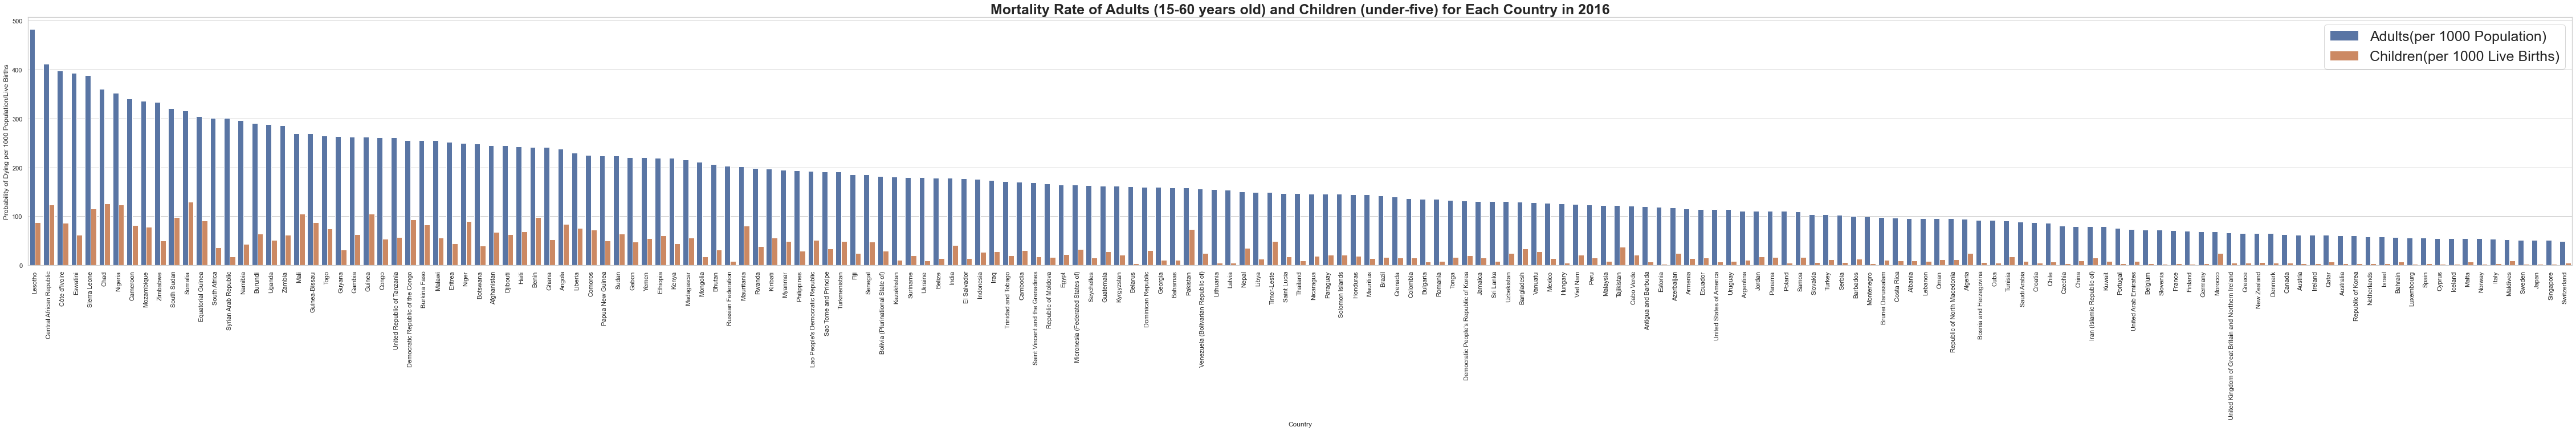

In [15]:
plt.figure(figsize = (80,8))
bar = sb.barplot(x="Country", y="value", hue="variable", data=vis_1)

hands, labs = bar.get_legend_handles_labels()

plt.title("Mortality Rate of Adults (15-60 years old) and Children (under-five) for Each Country in 2016", 
          {'fontsize': 25, 'fontweight': "bold"})
plt.ylabel("Probability of Dying per 1000 Population/Live Births")
plt.xticks(rotation='vertical')
plt.legend(handles=hands, labels=['Adults(per 1000 Population)', 'Children(per 1000 Live Births)'], fontsize=25)

plt.show()

Bar chart shows the mortality rate of adults and children for the year 2016 of each countries. Arranged in descending order of adults mortality rate. Countries with high adult mortality rate, generally have high child mortality rate too.

## Second Visualisation:

In [16]:
query = """ 

SELECT Country, Year, [Both sexes(neonatal)]
FROM child_rate
WHERE Country IN (SELECT Country
                  FROM child_rate
                  GROUP BY Country
                  ORDER BY AVG([Both sexes(neonatal)]) DESC
                  LIMIT 10)

"""
vis_2 = pd.read_sql(query, db_conn)
vis_2.head()

,Country,Year,Both sexes(neonatal)
0,Afghanistan,2018,37.1
1,Afghanistan,2017,38.1
2,Afghanistan,2016,39.3
3,Afghanistan,2015,40.5
4,Afghanistan,2014,41.9


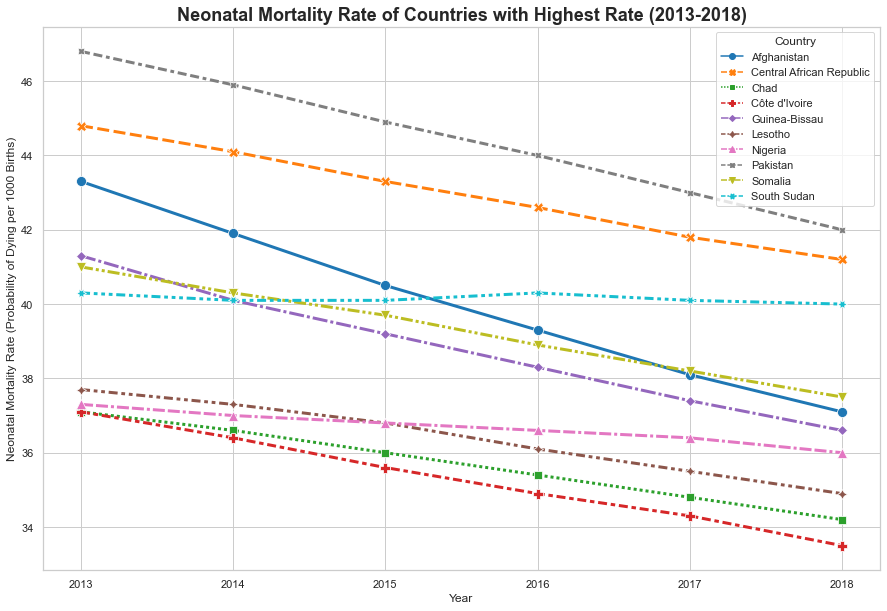

In [17]:
plt.figure(figsize = (15,10))
sb.lineplot(x="Year", y="Both sexes(neonatal)", hue="Country", data=vis_2, 
            style="Country", palette="tab10", markers=True, linewidth=3, markersize=10)

plt.title("Neonatal Mortality Rate of Countries with Highest Rate (2013-2018)", 
          {'fontsize': 18, 'fontweight': "bold"})
plt.ylabel("Neonatal Mortality Rate (Probability of Dying per 1000 Births)")

plt.show()

Line graph shows the change of neonatal mortality rate from year 2013 to 2018 of 10 countries with the highest rate of neonatal mortality on average. In general, the neonatal mortality rate of the countries has a downwards trend which shows that the situation of poor healthcare for newborn babies might be improving along the years.

## Third Visualisation:

In [18]:
query = """ 

SELECT Year, SUM([Both sexes(under-5)])/1000000.0 AS Children, 
SUM([Both sexes(infant)])/1000000.0 AS Infants, 
SUM([Both sexes(neonatal)])/1000000.0 AS Neonatals
FROM Child
GROUP BY Year

"""
vis_3 = pd.read_sql(query, db_conn)
vis_3 = vis_3.set_index("Year")
vis_3.head()

,Children,Infants,Neonatals
Year,,,
2013,6.216145,4.601946,2.809065
2014,6.013338,4.467590,2.735020
2015,5.825206,4.341622,2.667197
2016,5.650998,4.226521,2.601740
2017,5.477799,4.107185,2.535914


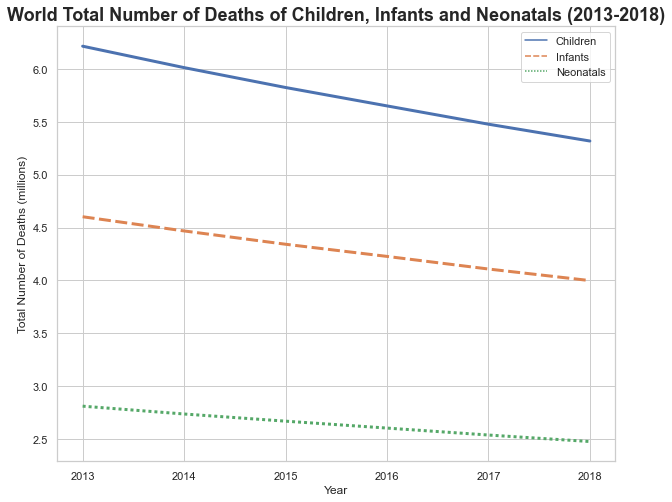

In [19]:
plt.figure(figsize = (10,8))

sb.lineplot(data=vis_3, linewidth=3)
plt.title("World Total Number of Deaths of Children, Infants and Neonatals (2013-2018)", 
          {'fontsize': 18, 'fontweight': "bold"})
plt.ylabel("Total Number of Deaths (millions)")

plt.show()

Line graph shows the changes in the total number of deaths of children, infants and neonatals globally from year 2013 to 2018. The number of deaths of children, infants and neonatals declined every year which indicates that the healthcare for the vulnerables are being attended.